This is the notebook with basic statistik of SemEval-2016 russian reviews of restaurants.

In [1]:
import logging
import copy
import os
import sys
from functools import reduce
from collections import Counter, defaultdict
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from absa import TEST_APPENDIX, parsed_reviews_dump_path, images_path, raw_reviews_dump_path
from absa.utils.dump import load_dump
from absa.utils.embedding import Embeddings
from absa.text.opinion.polarity import Polarity

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
logging.basicConfig(level=logging.INFO)

seed = 42
np.random.seed(seed)

# Upload

In [2]:
train_raw_reviews = load_dump(pathway=raw_reviews_dump_path)
test_raw_reviews = load_dump(pathway=raw_reviews_dump_path + TEST_APPENDIX)

INFO:root:Upload from dump: /home/dmitry/Projects/absa/dumps/data/reviews
INFO:root:Upload from dump: /home/dmitry/Projects/absa/dumps/data/reviews.test


In [3]:
print(f'Number of train reviews: {len(train_raw_reviews)}')
print(f'Number of test reviews:  {len(test_raw_reviews)}')

Number of train reviews: 312
Number of test reviews:  103


# Sentiment distribution

There is only one 'conflict' polarity

In [4]:
texts = train_raw_reviews

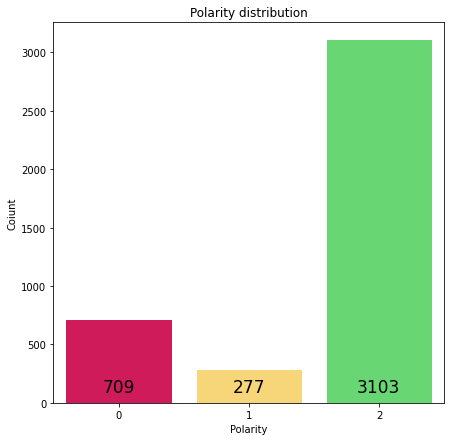

In [5]:
polarity_count = Counter()

for text in texts:
    for opinion in text.opinions:
        polarity_count.update([opinion.polarity])
        
xy = [(x.value, y) for x, y in sorted(polarity_count.items(), key=lambda item: item[0].value)]
x = [i[0] for i in xy]
y = [j[1] for j in xy]
            
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
bar_plot = ax.bar(x, y, color='#0000ff', zorder=5)
bar_plot[Polarity.positive.value].set_color('#67D673')
bar_plot[Polarity.neutral.value].set_color('#F7D579')
bar_plot[Polarity.negative.value].set_color('#CF1B5A')
plt.xlim(left=-0.5, right=2.5)
for x, y in xy:
    ax.text(x=x-0.05*len(str(y)) + 0.03, 
            y=90, 
            s=y, 
            fontsize=17,
            color='black',
            zorder=10,)
plt.xticks([0, 1, 2])
plt.xlabel('Polarity')
plt.ylabel('Coiunt')
plt.title('Polarity distribution')
plt.savefig(os.path.join(images_path, 'polarity_distribution.pdf'))

# Aspect categories

Print all aspect categories

In [6]:
texts = train_raw_reviews + test_raw_reviews
aspects = set()

for text in texts:
    for opinion in text.opinions:
        aspects.add(opinion.category)

for aspect in sorted(aspects):
    print(aspect)

AMBIENCE#GENERAL
DRINKS#PRICES
DRINKS#QUALITY
DRINKS#STYLE_OPTIONS
FOOD#PRICES
FOOD#QUALITY
FOOD#STYLE_OPTIONS
LOCATION#GENERAL
RESTAURANT#GENERAL
RESTAURANT#MISCELLANEOUS
RESTAURANT#PRICES
SERVICE#GENERAL


### Mark one target as different aspects

[3007   73    2]
[873  27   1]


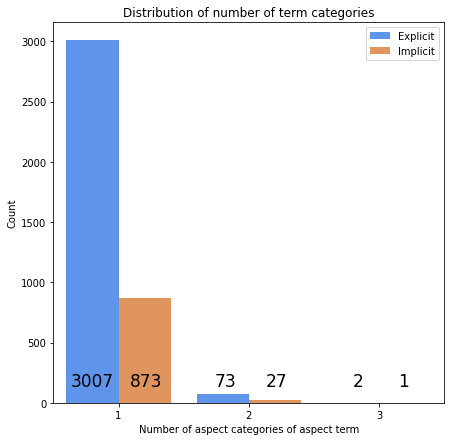

In [82]:
texts = train_raw_reviews

def get_category_count(explicit=True):
    explicit_category_count = Counter()

    for text in texts:
        if text.opinions:
            sentence_category = defaultdict(lambda: 0)
            for opinion in text.opinions:
                if explicit ^ (opinion.is_implicit()):
                    sentence_category[frozenset((opinion.start_index, opinion.stop_index))] += 1
            explicit_category_count.update(Counter(sentence_category.values()))

    xy = [(x, y) for x, y in sorted(explicit_category_count.items(), key=lambda item: item[0])]
    x = np.array([i[0] for i in xy])
    y = np.array([j[1] for j in xy])
    return x, y
       
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
text_display_params = {
    'y': 140,
    'fontsize': 17,
    'color': 'black',
    'zorder': 10,
}

# ------- Explicit ------------
x, y = get_category_count(explicit=True)
print(y)
x = x - 0.2
bar_plot = ax.bar(x, y, color='#5E95EB', zorder=5, width = 0.4)
plt.xlim(left=0.5, right=3.5)
ax.text(x=0.63, s=y[0], **text_display_params)
ax.text(x=1.74, s=y[1], **text_display_params)
ax.text(x=2.8, s=y[2], **text_display_params)
    
# ------- Implicit ------------
x, y = get_category_count(explicit=False)
print(y)
x = x + 0.2
bar_plot = ax.bar(x, y, color='#E0945E', zorder=5, width = 0.4)
ax.text(x=1.09, s=y[0], **text_display_params)
ax.text(x=2.13, s=y[1], **text_display_params)
ax.text(x=3.15, s=y[2], **text_display_params)
    

plt.xticks([1, 2, 3])
plt.xlabel('Number of aspect categories of aspect term')
plt.ylabel('Count')
plt.title('Distribution of number of term categories')
ax.legend(['Explicit', 'Implicit'])
plt.savefig(os.path.join(images_path, 'number_term_categories_distribution.pdf'))

### Implicit opinions

In [8]:
implicit_opinions = 0

for text in train_raw_reviews:
    for opinion in text.opinions:
        if opinion.is_implicit():
            implicit_opinions += 1
                
implicit_opinions

930

## Distributions

### Aspect

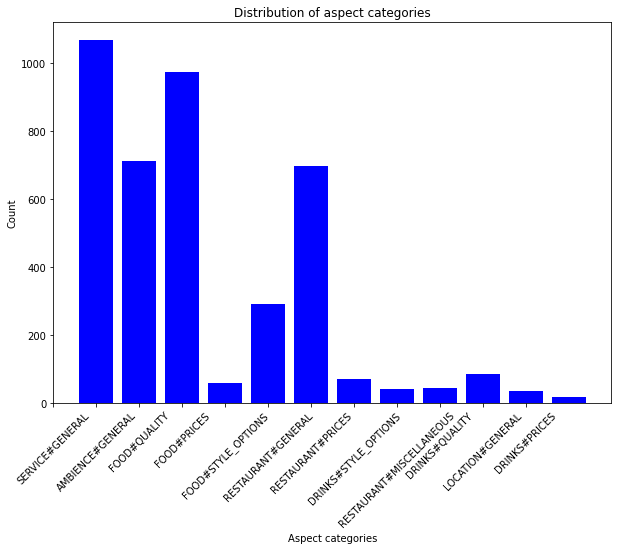

In [9]:
texts = train_raw_reviews
entity_counter = Counter()

for text in texts:
    for opinion in text.opinions:
        entity_counter.update([opinion.category])
           
labels = [x for x in entity_counter.keys()]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
#ax.grid('on', zorder=0)
plt.bar(entity_counter.keys(), entity_counter.values(), color='#0000ff', zorder=5)
plt.xticks(ticks=[x-1 for x in range(len(entity_counter))], labels=labels, rotation=45)
plt.title('Distribution of aspect categories')
plt.xlabel('Aspect categories')
plt.ylabel('Count');

### Entity

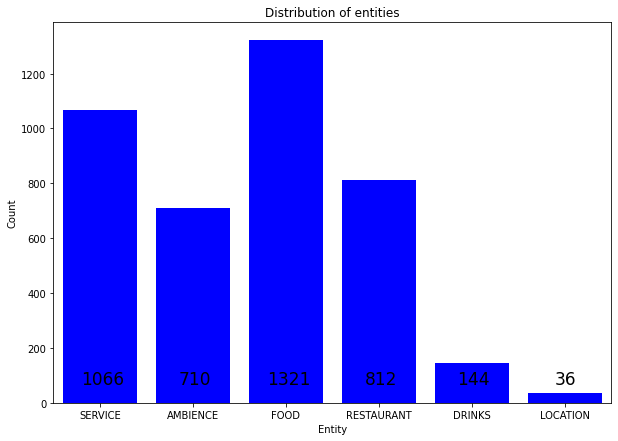

In [12]:
texts = train_raw_reviews
entity_counter = Counter()

for text in texts:
    for opinion in text.opinions:
        entity_counter.update([opinion.category.split('#')[0]])
            
labels = [x for x in entity_counter.values()]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
ax.bar(entity_counter.keys(), entity_counter.values(), color='#0000ff', zorder=5)
plt.xlim(left=-0.5, right=5.5)
for i, v in enumerate(labels):
    ax.text(x=i-0.05*len(str(labels[i]))-0.005, 
            y=70, 
            s=labels[i], 
            fontsize=17,
            #color='black' if i==3 else 'white',
            zorder=10,)
plt.xlabel('Entity')
plt.ylabel('Count')
plt.title('Distribution of entities');

### Attribute

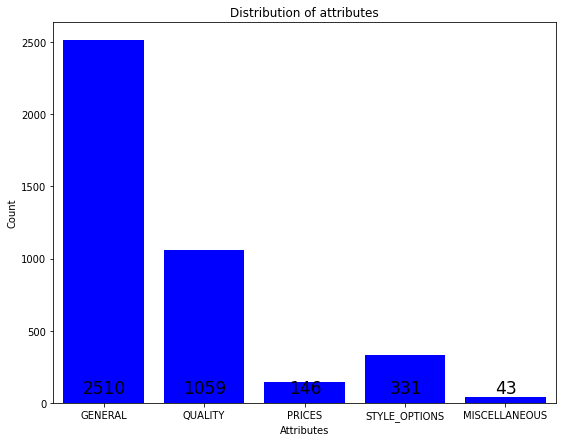

In [15]:
texts = train_raw_reviews
attribute_counter = Counter()

for text in texts:
    for opinion in text.opinions:
        attribute_counter.update([opinion.category.split('#')[1]])
            
labels = [x for x in attribute_counter.values()]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))
ax.bar(attribute_counter.keys(), attribute_counter.values(), color='#0000ff', zorder=5)
plt.xlim(left=-0.5, right=4.5)
for i, v in enumerate(labels):
    ax.text(x=i-0.05*len(str(labels[i]))-0.005, 
            y=70, 
            s=labels[i], 
            fontsize=17,
            zorder=10,)
plt.xlabel('Attributes')
plt.ylabel('Count')
plt.title('Distribution of attributes');